<a href="https://colab.research.google.com/github/dewanshrawat15/Style-Transfer/blob/main/Style%20Transfer%20%E2%80%93%20Painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

TensorFlow 1.x selected.


In [ ]:
!wget https://s3.amazonaws.com/cadl/models/vgg16.tfmodel

--2021-06-16 09:09:54--  https://s3.amazonaws.com/cadl/models/vgg16.tfmodel
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553439629 (528M) [application/octet-stream]
Saving to: ‘vgg16.tfmodel’

vgg16.tfmodel       100%[===================>] 527.80M  48.6MB/s    in 12s     

2021-06-16 09:10:06 (44.6 MB/s) - ‘vgg16.tfmodel’ saved [553439629/553439629]



In [ ]:
import vgg16

In [ ]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        factor = max_size / np.max(image.size)
        size = np.array(image.size) * factor
        size = size.astype(int)
        image = image.resize(size, PIL.Image.LANCZOS)

    return np.float32(image)

In [ ]:
def save_image(image, filename):
    print(type(image))
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [ ]:
def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    display(PIL.Image.fromarray(image))

In [ ]:
def plot_images(content_image, style_image, mixed_image):
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    smooth = True
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")
    
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [ ]:
def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image=content_image)
    layers = model.get_layer_tensors(layer_ids)
    values = session.run(layers, feed_dict=feed_dict)
    with model.graph.as_default():
        layer_losses = []
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [ ]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

In [ ]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    feed_dict = model.create_feed_dict(image=style_image)
    layers = model.get_layer_tensors(layer_ids)
    with model.graph.as_default():
        gram_layers = [gram_matrix(layer) for layer in layers]
        values = session.run(gram_layers, feed_dict=feed_dict)
        layer_losses = []
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [ ]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [ ]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    model = vgg16.VGG16()
    session = tf.InteractiveSession(graph=model.graph)
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    
    loss_denoise = create_denoise_loss(model)
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise
    gradient = tf.gradients(loss_combined, model.input)

    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]
    mixed_image = np.random.rand(*content_image.shape) + 128

    session.close()
    return mixed_image

In [ ]:
!pwd

/content


In [ ]:
content_filename = '8.jpeg'
content_image = load_image(content_filename, max_size=None)

In [ ]:
style_filename = 'style.jpeg'
style_image = load_image(style_filename, max_size=300)

In [ ]:
content_layer_ids = [4]

In [ ]:
style_layer_ids = list(range(13))

In [ ]:
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=2.5)

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']



In [ ]:
save_image(img, 'output.jpeg')

<class 'numpy.ndarray'>


Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.13e-11, Style: 1.81e-28, Denoise: 9.95e-06


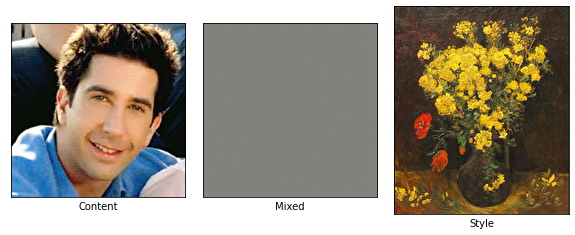

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 7.08e-11, Style: 3.52e-28, Denoise: 5.94e-07


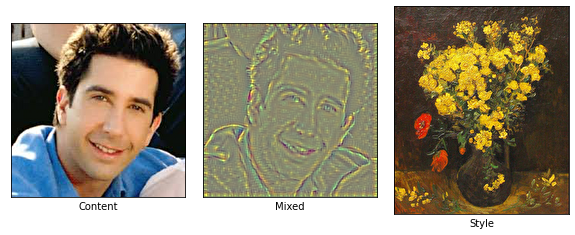

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 5.68e-11, Style: 2.20e-27, Denoise: 3.19e-07


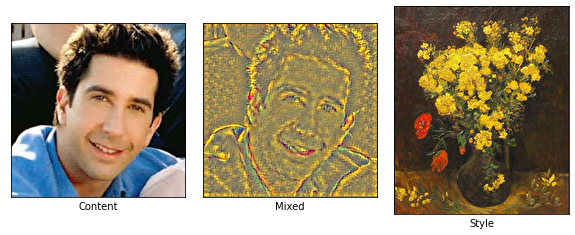

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 5.52e-11, Style: 1.11e-26, Denoise: 2.97e-07


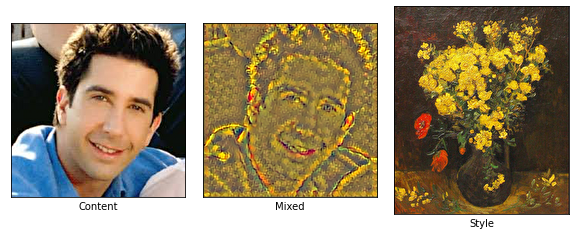

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 5.37e-11, Style: 2.03e-26, Denoise: 2.86e-07


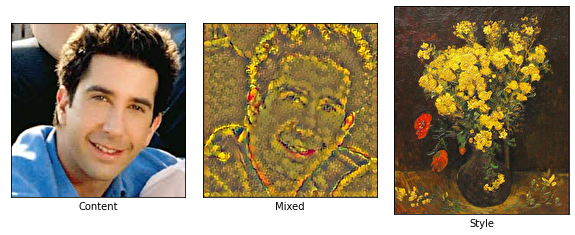

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 5.22e-11, Style: 3.13e-26, Denoise: 2.76e-07


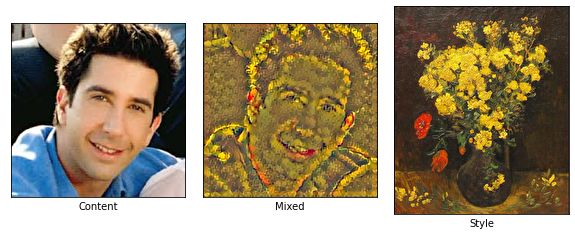

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 5.50e-11, Style: 2.34e-26, Denoise: 2.92e-07


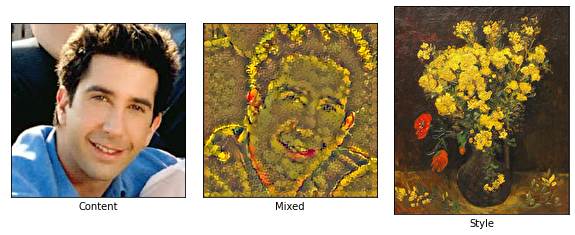


Final image:


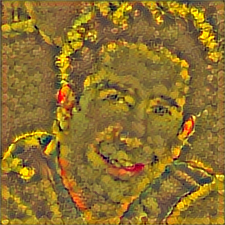

In [ ]:
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=2.5)